# Imports

In [56]:
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import os

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf


# Cosntansts

In [57]:
IMG_W = 256
IMG_H = 256

MODEL_WEIGHTS_PATH = r'best_model_layers_weights'

# G

In [58]:
def build_generator_v2(img_w, img_h):
    """Improved generator with better color handling"""


    def SE_Block(input_tensor, reduction=16):
        """Squeeze-and-Excitation block"""
        filters = input_tensor.shape[-1]
        se = GlobalAveragePooling2D()(input_tensor)
        se = Dense(filters // reduction, activation='relu')(se)
        se = Dense(filters, activation='sigmoid')(se)
        se = Reshape((1, 1, filters))(se)
        return Multiply()([input_tensor, se])

    def ResidualBlock(x, filters):
        """Residual block with batch normalization"""
        shortcut = x
        x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = LeakyReLU(0.2)(x)
        x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = Add()([shortcut, x])
        x = LeakyReLU(0.2)(x)
        return x

    inputs = Input((img_h, img_w, 2))
    
    # Encoder with better initialization
    e1 = Conv2D(64, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_1')(inputs)
    e1 = LeakyReLU(0.2)(e1)
    
    e2 = Conv2D(128, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_2')(e1)
    e2 = BatchNormalization(momentum=0.9)(e2)
    e2 = LeakyReLU(0.2)(e2)
    
    e3 = Conv2D(256, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_3')(e2)
    e3 = BatchNormalization(momentum=0.9)(e3)
    e3 = LeakyReLU(0.2)(e3)
    
    e4 = Conv2D(512, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_4')(e3)
    e4 = BatchNormalization(momentum=0.9)(e4)
    e4 = LeakyReLU(0.2)(e4)
    
    # Bottleneck
    b = Conv2D(1024, 4, strides=2, padding='same', 
               kernel_initializer='he_normal', name='bottleneck')(e4)
    b = BatchNormalization(momentum=0.9)(b)
    b = Activation('relu')(b)
    
    # Fewer residual blocks to prevent over-processing
    for i in range(2):
        b = ResidualBlock(b, 1024)
    
    b = SE_Block(b)
    
    # Decoder
    d1 = Conv2DTranspose(512, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_1')(b)
    d1 = BatchNormalization(momentum=0.9)(d1)
    d1 = Dropout(0.2)(d1)  # Reduced dropout
    d1 = Activation('relu')(d1)
    d1 = Concatenate()([d1, e4])
    
    d2 = Conv2DTranspose(256, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_2')(d1)
    d2 = BatchNormalization(momentum=0.9)(d2)
    d2 = Dropout(0.2)(d2)
    d2 = Activation('relu')(d2)
    d2 = Concatenate()([d2, e3])
    
    d3 = Conv2DTranspose(128, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_3')(d2)
    d3 = BatchNormalization(momentum=0.9)(d3)
    d3 = Activation('relu')(d3)
    d3 = Concatenate()([d3, e2])
    
    d4 = Conv2DTranspose(64, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_4')(d3)
    d4 = BatchNormalization(momentum=0.9)(d4)
    d4 = Activation('relu')(d4)
    d4 = Concatenate()([d4, e1])
    
    d5 = Conv2DTranspose(32, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_5')(d4)
    d5 = BatchNormalization(momentum=0.9)(d5)
    d5 = Activation('relu')(d5)
    
    # IMPROVED: Dual-branch output for better color control
    # Structure branch (main details)
    structure = Conv2D(3, 3, padding='same', activation='tanh', 
                      kernel_initializer='glorot_normal', name='structure_out')(d5)
    
    # Color refinement branch (subtle color adjustments)
    color_refine = Conv2D(3, 1, padding='same', activation='tanh', 
                         kernel_initializer='zeros', name='color_out')(d5)
    
    # Combine: favor structure but allow color refinement
    outputs = Add(name='final_output')([0.8 * structure, 0.2 * color_refine])
    
    return Model(inputs, outputs, name='generator')

# Load Model

In [59]:
import numpy as np

def load_layer_weights(model, save_dir='layer_weights'):

    for i, layer in enumerate(model.layers):
        layer_path = os.path.join(save_dir, f'layer_{i}.npz')
        if os.path.exists(layer_path):
            data = np.load(layer_path)
            weights = [data[f'arr_{j}'] for j in range(len(data.files))]
            layer.set_weights(weights)
            print(f"Loaded weights into {layer.name} from {layer_path}")

generator_model = build_generator_v2(IMG_W, IMG_H)
load_layer_weights(generator_model, MODEL_WEIGHTS_PATH)

Loaded weights into enc_1 from best_model_layers_weights\layer_1.npz
Loaded weights into enc_2 from best_model_layers_weights\layer_3.npz
Loaded weights into batch_normalization_91 from best_model_layers_weights\layer_4.npz
Loaded weights into enc_3 from best_model_layers_weights\layer_6.npz
Loaded weights into batch_normalization_92 from best_model_layers_weights\layer_7.npz
Loaded weights into enc_4 from best_model_layers_weights\layer_9.npz
Loaded weights into batch_normalization_93 from best_model_layers_weights\layer_10.npz
Loaded weights into bottleneck from best_model_layers_weights\layer_12.npz
Loaded weights into batch_normalization_94 from best_model_layers_weights\layer_13.npz
Loaded weights into conv2d_28 from best_model_layers_weights\layer_15.npz
Loaded weights into batch_normalization_95 from best_model_layers_weights\layer_16.npz
Loaded weights into conv2d_29 from best_model_layers_weights\layer_18.npz
Loaded weights into batch_normalization_96 from best_model_layers_we

# Data

In [60]:
def preprocess_image(image_path):
    """Preprocess the input image for the model."""
    
    edge_img = cv2.imread(image_path)
    edge_img = cv2.cvtColor(edge_img, cv2.COLOR_BGR2GRAY)
    edge_img = cv2.resize(edge_img, (IMG_W, IMG_H))
    
    edge_img = (edge_img / 255.0) * 2 - 1 # Normalize to [-1, 1]
    edge_img = edge_img.astype(np.float32)
    edge_img = np.squeeze(edge_img)

    noise_channel = np.random.uniform(-1, 1, size=edge_img.shape).astype(np.float32) * 1.0

    input_img = np.stack([edge_img, noise_channel], axis=-1)

    print(f"Input image shape: {input_img.shape}", noise_channel.shape, edge_img.shape)
    
    return input_img

In [61]:
def predict_image(img_with_noise):    
    """Predict the output image from the input edge image."""

    global generator_model

    input_img = np.expand_dims(img_with_noise, axis=0)  # Add batch dimension
    
    output_img = generator_model.predict(input_img)
    output_img = (output_img[0] + 1) / 2  # Rescale to [0, 1]
    output_img = (output_img * 255).astype(np.uint8)
    
    return output_img

# Test

Input image shape: (256, 256, 2) (256, 256) (256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


(-0.5, 255.5, 255.5, -0.5)

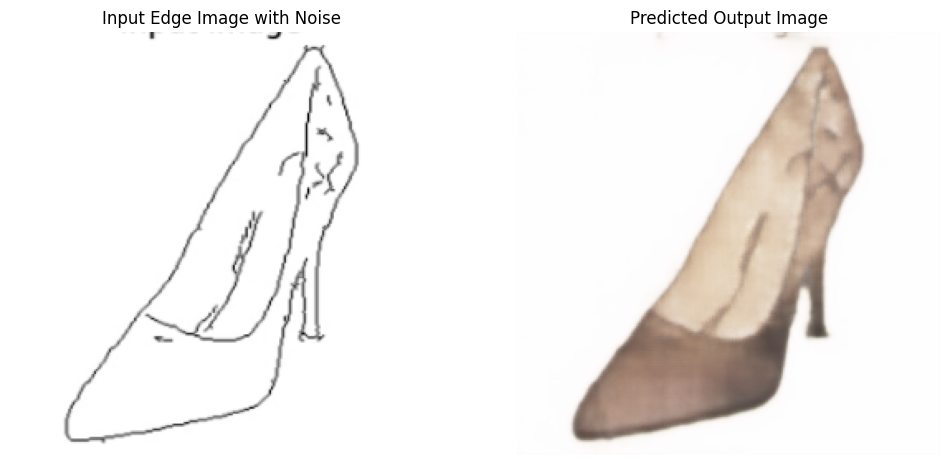

In [62]:
img_path = 'image.png'  # Replace with your image path

img_with_noise = preprocess_image(img_path)
output_img = predict_image(img_with_noise)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_with_noise[:, :, 0], cmap='gray')
plt.title('Input Edge Image with Noise')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_img)
plt.title('Predicted Output Image')
plt.axis('off')